In [1]:
from google.cloud import vision
import io

import json
import pandas as pd

from PIL import Image
import string
from fuzzywuzzy import process
import numpy as np

In [2]:
def detect_text(path):
    """Detects text in the file."""

    client = vision.ImageAnnotatorClient()

    with io.open(path, 'rb') as image_file:
        content = image_file.read()

    image = vision.Image(content=content)

    response = client.text_detection(image=image)
    texts = response.text_annotations


    if response.error.message:
        raise Exception(
            '{}\nFor more info on error messages, check: '
            'https://cloud.google.com/apis/design/errors'.format(
                response.error.message))
    return texts

In [4]:
file_path =  'test_images/test4.jpg'
texts = detect_text(file_path)

In [49]:
# for text in texts:
#     print('\n"{}"'.format(text.description))

#     vertices = (['({},{})'.format(vertex.x, vertex.y)
#                 for vertex in text.bounding_poly.vertices])

#     print('bounds: {}'.format(','.join(vertices)))

In [47]:
def build_list():
    list_dict = {}
    with open('list.json') as fp:
        list_dict = json.load(fp)

    ohel_torah = [ing['_source']['product_name_text'] for ing in list_dict['hits']['hits']]
    df = pd.read_csv('Pesach-List-2022.csv')
    ingredients_df = df[df['Category'] == 'Ingredient']

    full_list = np.append(ingredients_df.Item.values, ohel_torah)
    return full_list

In [51]:
full_list = build_list()

In [8]:
# for text in texts:
#     print(text.description)

INGREDIENTS: ALMONDS, CASHEWS, SEASONING
(SESAME SEEDS, BLACK SESAME SEEDS, SALT,
POPPY SEEDS, NATURAL FLAVORS), CORN
SYRUP SOLIDS, SUNFLOWER OIL

INGREDIENTS:
ALMONDS,
CASHEWS,
SEASONING
(SESAME
SEEDS,
BLACK
SESAME
SEEDS,
SALT,
POPPY
SEEDS,
NATURAL
FLAVORS),
CORN
SYRUP
SOLIDS,
SUNFLOWER
OIL


In [52]:

 
# Opens a image in RGB mode
im = Image.open(file_path)

def crop_image(im, left, upper, right, lower):
    # Cropped image of above dimension
    # (It will not change original image)
    im1 = im.crop((left, upper, right, lower))

    # Shows the image in image viewer
    return im1

In [53]:
def process_results(texts, im):
    last = []
    c_l, c_t, c_r, c_b = im.size[0], im.size[1], 0, 0
    processed_texts = []
    bboxes = []
    for text in texts:
        if len(text.description.split()) == 1 and 'ingredients' not in text.description.lower():
            l,t = text.bounding_poly.vertices[0].x, text.bounding_poly.vertices[0].y
            r,b = text.bounding_poly.vertices[2].x, text.bounding_poly.vertices[2].y      
            c_l = min(c_l, l)
            c_t = min(c_t, t)
            c_r = max(c_r, r)
            c_b = max(c_b, b)
            
            last.append(text.description)
            if text.description[-1] in ',:':
                processed_texts.append(' '.join(last))
                bboxes.append((c_l, c_t, c_r, c_b))
                last = []
                c_l, c_t, c_r, c_b = im.size[0], im.size[1], 0, 0
    return processed_texts, bboxes


In [55]:
texts = detect_text(file_path)
im = Image.open(file_path)

texts, bboxes = process_results(texts, im)
full_list = build_list()

x = []
for bbox, text in zip(bboxes, texts):
    highest = process.extract(text,full_list)
    # im_c = crop_image(im, *bbox)
    # display(im_c)
    x.append([text, *highest[:3]])

In [56]:
x

[['ALMONDS,',
  ('Nut, Almond', 83),
  ('Earth Almond (tigernut)', 77),
  ('Pacific salmon', 75)],
 ['CASHEWS,', ('Casein', 62), ('Lactase', 57), ('Catalase', 53)],
 ['SEASONING (SESAME SEEDS,',
  ('Sesame seed', 90),
  ('Hemp Seeds', 86),
  ('Seed - Sesame', 86)],
 ['BLACK SESAME SEEDS,',
  ('Sesame seed', 90),
  ('Hemp Seeds', 86),
  ('Sesame oil', 86)],
 ['SALT,', ('Salt', 100), ('Salt', 100), ('Mineral Salts', 90)],
 ['POPPY SEEDS,', ('Poppy', 90), ('Hemp Seeds', 67), ('HPP', 60)],
 ['NATURAL FLAVORS),',
  ('Natural Flavors', 100),
  ('Natural flavors', 100),
  ('Natural Flavoring', 88)],
 ['CORN SYRUP SOLIDS,',
  ('Corn Syrup Solids', 100),
  ('Corn', 90),
  ('Corn Syrup', 90)]]

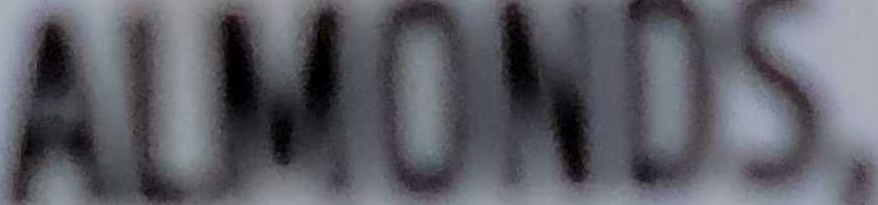

ALMONDS, [('Nut, Almond', 83), ('Earth Almond (tigernut)', 77), ('Pacific salmon', 75)]


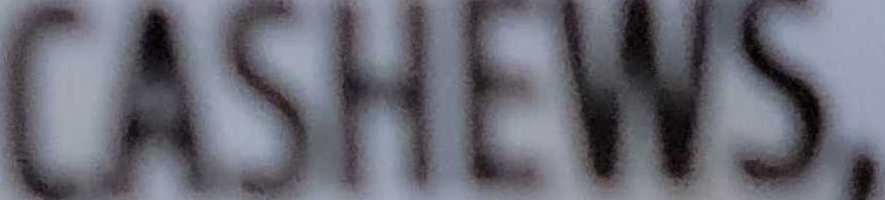

CASHEWS, [('Casein', 62), ('Lactase', 57), ('Catalase', 53)]


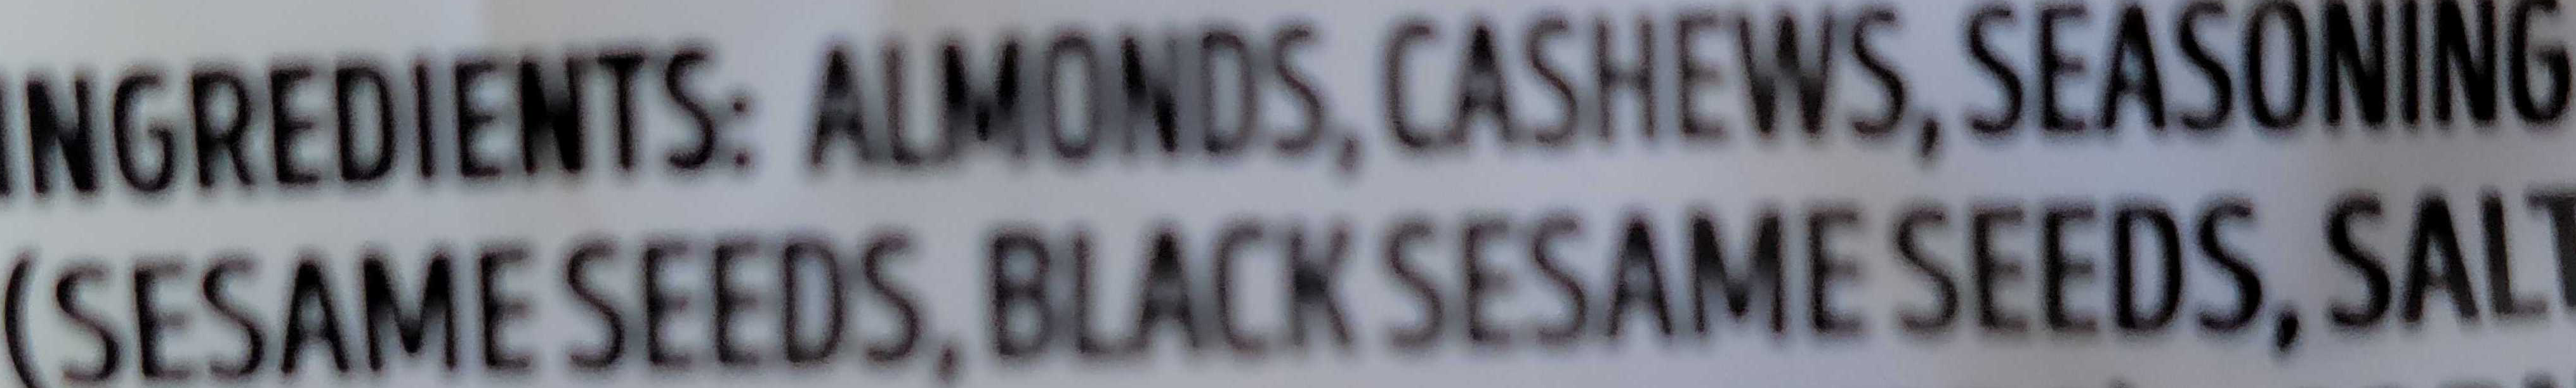

SEASONING (SESAME SEEDS, [('Sesame seed', 90), ('Hemp Seeds', 86), ('Seed - Sesame', 86)]


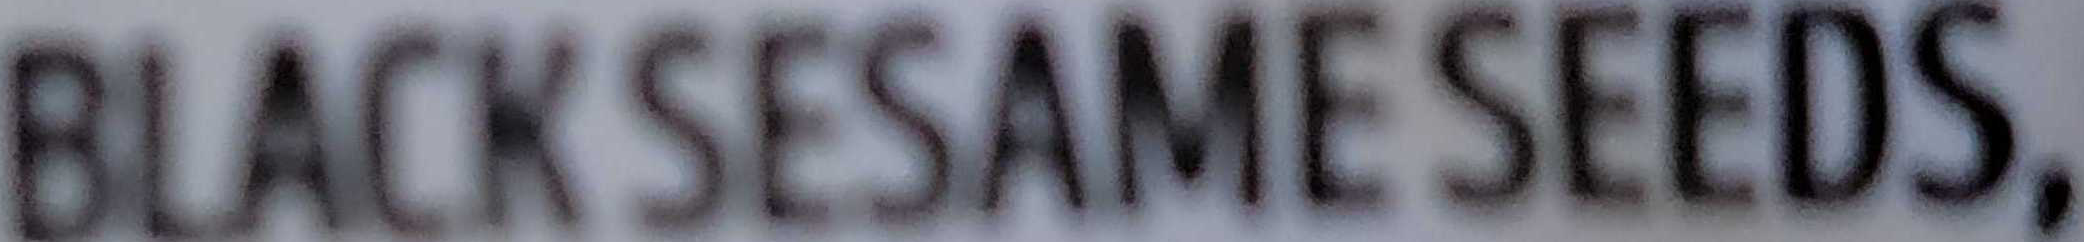

BLACK SESAME SEEDS, [('Sesame seed', 90), ('Hemp Seeds', 86), ('Sesame oil', 86)]


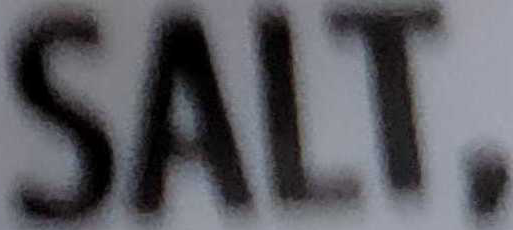

SALT, [('Salt', 100), ('Salt', 100), ('Mineral Salts', 90)]


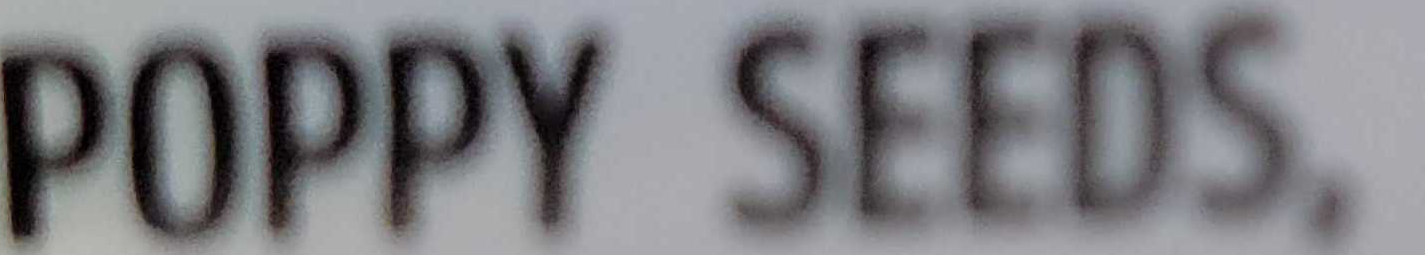

POPPY SEEDS, [('Poppy', 90), ('Hemp Seeds', 67), ('HPP', 60)]


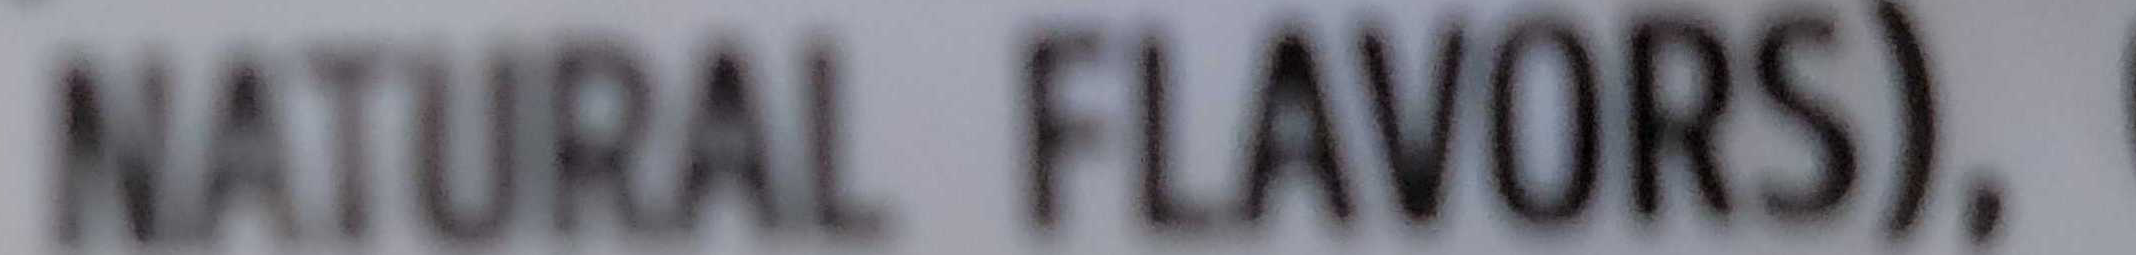

NATURAL FLAVORS), [('Natural Flavors', 100), ('Natural flavors', 100), ('Natural Flavoring', 88)]


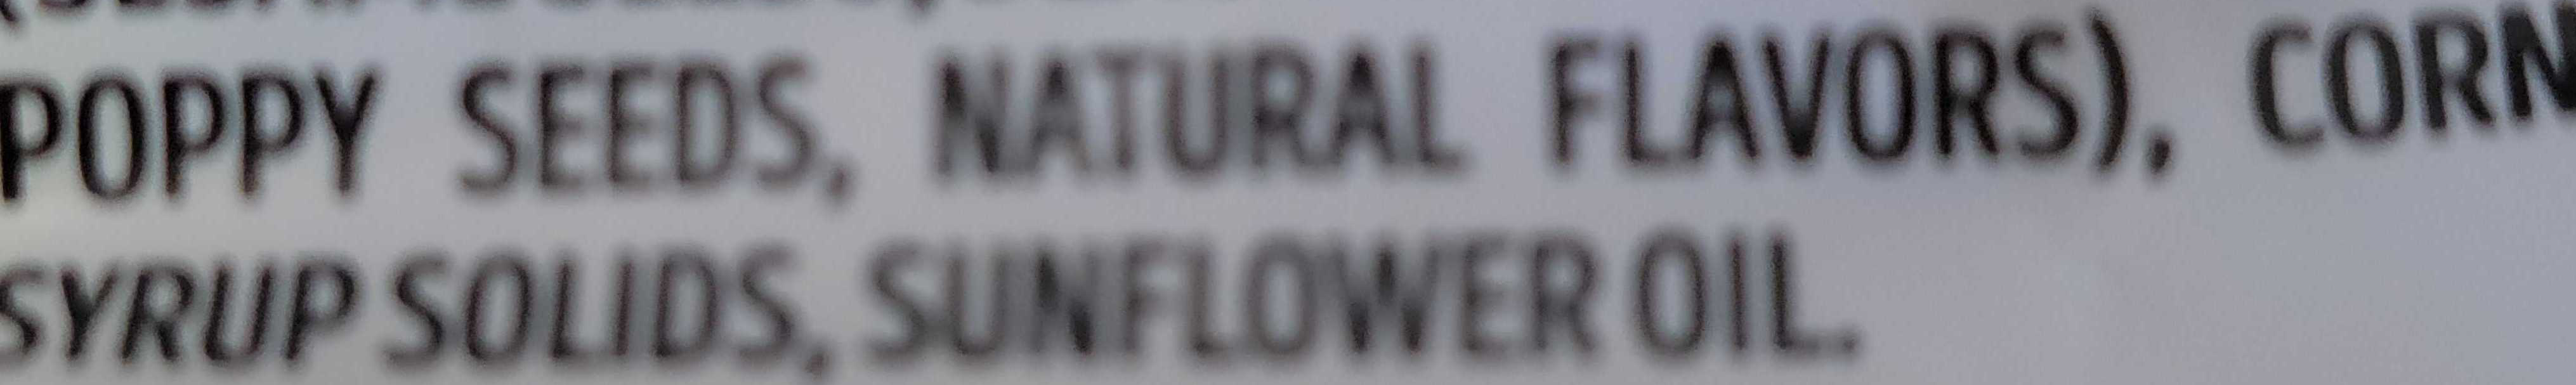

CORN SYRUP SOLIDS, [('Corn Syrup Solids', 100), ('Corn', 90), ('Corn Syrup', 90)]


In [45]:
for bbox, text in zip(bboxes, processed_texts):
    highest = process.extract(text,full_list)
    im_c = crop_image(im, *bbox)
    display(im_c)
    print(text, highest[:3])